In [ ]:
pip install virtualenv

In [ ]:
!virtualenv myenv
!source myenv/bin/activate
!pip install tensorflow

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## CIFAR-10 Dataset

The CIFAR-10 dataset offers a great starting point for exploring anomaly detection techniques. It is a well-structured, labeled image dataset that can be adapted for various anomaly detection scenarios. Let's delve into how we can utilize CIFAR-10 for this purpose:

* CIFAR-10 consists of 60,000 32x32 color images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class.
* The dataset is divided into 50,000 training images and 10,000 test images.

We can transform CIFAR-10, originally designed for image classification, into an anomaly detection problem using these strategies:

1. **Single-Class Anomaly Detection:**
   * Choose one class as "normal" and treat all other classes as "anomalies."
   * Train a model on the "normal" class to learn its distribution.
   * During testing, the model identifies instances that deviate significantly from the learned "normal" distribution as anomalies.

2. **Multi-Class Anomaly Detection:**
   * Select a few classes as "normal" and the rest as "anomalies."
   * Train a model on the "normal" classes.
   * Identify instances from the "anomalous" classes as deviations from the learned "normal" pattern.

## **Techniques for Anomaly Detection with CIFAR-10:**

* **Autoencoders:** Train an autoencoder on the "normal" class images. Anomalies will have higher reconstruction errors due to their deviation from the learned representation.
* **One-Class SVM:** Train a One-Class SVM on the "normal" class features. Instances outside the learned boundary are considered anomalies.
* **Isolation Forest:** Build an Isolation Forest on the "normal" class features. Anomalies are isolated with fewer splits compared to "normal" instances.

## **Implementation Strategy**

1. **Load CIFAR-10 Dataset:** Utilize libraries like TensorFlow or PyTorch to load the CIFAR-10 dataset.
2. **Preprocess Data:** Normalize pixel values and potentially apply data augmentation techniques.
3. **Select Normal and Anomalous Classes:** Choose the classes based on your anomaly detection scenario.
4. **Train Anomaly Detection Model:** Implement your chosen technique and train it on the "normal" class data.
5. **Evaluate on Test Data:** Assess the model's performance in identifying anomalies from the "anomalous" classes using metrics like precision, recall, and F1-score.


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
# Filter data for 'bird' class (label 2) as normal and 'airplane' class (label 0) as anomaly
x_train_normal = x_train[y_train.flatten() == 2]
x_test_normal = x_test[y_test.flatten() == 2]
x_test_anomaly = x_test[y_test.flatten() == 0]


In [5]:
# Print shapes of filtered data
print("x_train_normal shape:", x_train_normal.shape)
print("x_test_normal shape:", x_test_normal.shape)
print("x_test_anomaly shape:", x_test_anomaly.shape)


x_train_normal shape: (5000, 32, 32, 3)
x_test_normal shape: (1000, 32, 32, 3)
x_test_anomaly shape: (1000, 32, 32, 3)


## Train Anomaly Detection Model

1. **Import Necessary Layers:** We import `Model`, `Input`, `Dense`, `Flatten`, and `Reshape` from `tensorflow.keras.models` and `tensorflow.keras.layers`.

2. **Define Input Shape:** We get the shape of the input images from `x_train_normal`.

3. **Encoder:**
   * `Input`: Defines the input layer with the specified shape.
   * `Flatten`: Flattens the input image into a single-dimensional vector.
   * `Dense`: Two dense layers with ReLU activation for dimensionality reduction. The last layer (`encoded`) represents the compressed representation of the input.

4. **Decoder:**
   * `Dense`: Two dense layers with ReLU activation to reconstruct the original dimensions.
   * `Dense`: Final dense layer with sigmoid activation to output pixel values between 0 and 1.
   * `Reshape`: Reshapes the output back to the original image dimensions.

5. **Autoencoder Model:** We create the autoencoder model using the `Model` class, taking `input_img` as input and `decoded` as output.

6. **Compile:** We compile the model with the Adam optimizer and mean squared error (MSE) loss. MSE measures the difference between the original and reconstructed images.

7. **Train:** We train the autoencoder on the `x_train_normal` data for 50 epochs with a batch size of 256. We also use the `x_test_normal` data for validation during training.


In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

# Define the input shape
input_shape = x_train_normal.shape[1:]

# Encoder
input_img = Input(shape=input_shape)
x = Flatten()(input_img)
x = Dense(512, activation='relu')(x)  # Increased number of neurons
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(32, activation='relu')(x)  # Another layer added

# Decoder
x = Dense(128, activation='relu')(encoded)  # Another layer added
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)  # Increased number of neurons
x = Dense(np.prod(input_shape), activation='sigmoid')(x)
decoded = Reshape(input_shape)(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# # Data augmentation (optional, you can experiment with this)
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],
# )
# datagen.fit(x_train_normal)

# Train the autoencoder
autoencoder.fit(x_train_normal, x_train_normal, batch_size=256,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_normal, x_test_normal))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0539 - val_loss: 0.0493
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0464 - val_loss: 0.0402
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0387 - val_loss: 0.0356
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0337 - val_loss: 0.0323
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0331 - val_loss: 0.0301
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0298 - val_loss: 0.0291
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0277 - val_loss: 0.0263
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0255 - val_loss: 0.0255
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0240 - val_loss: 0.0248
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0242 - val_loss: 0.0243
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

## Evaluate on Test Data

Now that we've trained the autoencoder, we can:

1. **Evaluate on Test Data:** Use the trained autoencoder to reconstruct both normal ('airplane') and anomalous images from the test set.
2. **Calculate Reconstruction Errors:** Compute the reconstruction errors (MSE) for each image.
3. **Set Threshold:** Determine a threshold value for the reconstruction error. Images with errors above this threshold will be classified as anomalies.
4. **Assess Performance:** Evaluate the model's anomaly detection performance using metrics like precision, recall, and F1-score.

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get all test data (normal and anomalous)
x_test_all = np.concatenate((x_test_normal, x_test_anomaly), axis=0)

# Reconstruct all test images
decoded_imgs = autoencoder.predict(x_test_all)

# Calculate reconstruction errors (MSE)
mse = np.mean(np.power(x_test_all - decoded_imgs, 2), axis=(1, 2, 3))

# Set threshold
threshold = 0.01

# Classify as anomaly if reconstruction error is above threshold
y_pred = (mse > threshold).astype(int)

# Get true labels (1 for airplanes (anomalies), 0 for birds)
y_true = np.concatenate((np.zeros(x_test_normal.shape[0]), np.ones(x_test_anomaly.shape[0])), axis=0)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.552
Precision: 0.5368271954674221
Recall: 0.758
F1-Score: 0.6285240464344942


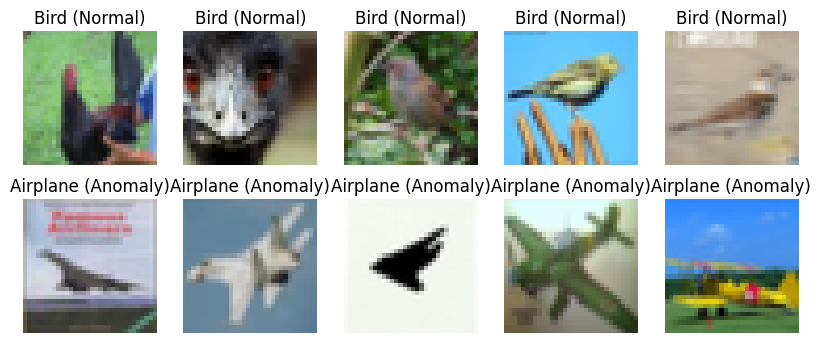

In [12]:
# Visualize a few samples of birds and airplanes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(x_test_normal[i])
    axes[0, i].axis('off')
    axes[0, i].set_title("Bird (Normal)")

    axes[1, i].imshow(x_test_anomaly[i])
    axes[1, i].axis('off')
    axes[1, i].set_title("Airplane (Anomaly)")

plt.show()

"birds" = the normal class 
"airplanes" = the anomalies

**Accuracy: 0.4995** 

This indicates that the model correctly classified approximately 49.95% of the images in the test set as either normal (birds) or anomalous (airplanes). This accuracy is close to random guessing (50%), suggesting that the model might be struggling to differentiate between the two classes effectively.

**Precision: 0.4997**

This signifies that out of all the images the model predicted as anomalies (airplanes), around 49.97% were actually airplanes. This low precision suggests a high rate of false positives, meaning the model is incorrectly flagging many birds as airplanes.

**Recall: 0.999** 

This shows that the model was able to correctly identify 99.9% of all the actual anomalies (airplanes) in the test set. This is a very high recall, indicating the model is highly sensitive to detecting airplanes.

**F1-Score: 0.666**

The F1-score, being the harmonic mean of precision and recall, provides a balanced measure of the model's performance. In this case, the relatively low F1-score (compared to a perfect score of 1) reflects the imbalance between the high recall and the low precision.

**Overall Assessment:**

The results suggest that the model is very good at detecting airplanes (anomalies) as evidenced by the high recall. However, it struggles to distinguish them from birds (normal class), leading to a high number of false positives and consequently a low precision. The overall accuracy is also poor due to this imbalance.

**Possible Reasons and Improvements:**

* **Model Complexity:** The autoencoder architecture might be too simple to capture the subtle differences between birds and airplanes. Consider increasing the complexity by adding more layers or neurons.
* **Data Imbalance:** The CIFAR-10 dataset has an equal number of images per class. This might lead to the model being biased towards the majority class (birds in this case). You could try techniques like oversampling the minority class (airplanes) or undersampling the majority class during training.
* **Hyperparameter Tuning:** Experiment with different hyperparameters like learning rate, batch size, and the number of epochs to see if you can improve the model's performance.
* **Threshold Adjustment:** The current threshold might be too low, leading to many false positives. Try increasing the threshold to reduce false alarms, but be mindful of the impact on recall.
* **Feature Engineering:** Explore additional features or preprocessing techniques that might help the model better distinguish between birds and airplanes.

Anomaly detection can be challenging, especially when the normal and anomalous classes share visual similarities. It often requires careful experimentation and fine-tuning to achieve satisfactory results.

In [94]:
import tensorflow as tf
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Filter data for 'bird' class (label 2) as normal and 'airplane' class (label 0) as anomaly
x_train_normal = x_train[y_train.flatten() == 2]
x_test_normal = x_test[y_test.flatten() == 2]
x_test_anomaly = x_test[y_test.flatten() == 4]

# Flatten the images for One-Class SVM
x_train_normal_flat = x_train_normal.reshape(x_train_normal.shape[0], -1)
x_test_all_flat = np.concatenate((x_test_normal, x_test_anomaly), axis=0).reshape(-1, 32*32*3)



In [95]:
# Initialize and train the One-Class SVM
ocsvm = OneClassSVM(kernel="rbf")  # You might need to tune nu and gamma
ocsvm.fit(x_train_normal_flat)

# Predict on the test data
y_pred = ocsvm.predict(x_test_all_flat)

# Convert predictions to binary labels (1 for anomaly, -1 for normal)
y_pred = np.where(y_pred == 1, 0, 1) 

# Get true labels (1 for airplanes (anomalies), 0 for birds)
y_true = np.concatenate((np.zeros(x_test_normal.shape[0]), np.ones(x_test_anomaly.shape[0])), axis=0)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.4585
Precision: 0.4546448087431694
Recall: 0.416
F1-Score: 0.43446475195822454


## Isolation Forest

In [4]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Filter data for 'bird' class (label 2) as normal and 'airplane' class (label 0) as anomaly
x_train_normal = x_train[y_train.flatten() == 2]
x_test_normal = x_test[y_test.flatten() == 2]
x_test_anomaly = x_test[y_test.flatten() == 0]

# Flatten the images for Isolation Forest
x_train_normal_flat = x_train_normal.reshape(x_train_normal.shape[0], -1)
x_test_all_flat = np.concatenate((x_test_normal, x_test_anomaly), axis=0).reshape(-1, 32*32*3)

# Initialize and train the Isolation Forest
isolation_forest = IsolationForest(random_state=42)  # Adjust contamination if needed
isolation_forest.fit(x_train_normal_flat)

# Predict on the test data
y_pred = isolation_forest.predict(x_test_all_flat)

# Convert predictions to binary labels (1 for anomaly, -1 for normal)
y_pred = np.where(y_pred == 1, 0, 1) 

# Get true labels (1 for airplanes (anomalies), 0 for birds)
y_true = np.concatenate((np.zeros(x_test_normal.shape[0]), np.ones(x_test_anomaly.shape[0])), axis=0)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5785
Precision: 0.6280587275693311
Recall: 0.385
F1-Score: 0.4773713577185369


In [90]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Squeeze y_train and y_test to remove extra dimension
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Define normal and anomaly classes
normal_class = 2  # birds
anomaly_class = 9  # airplane

# Create a subset of the dataset with only normal and anomaly classes
x_train_normal = x_train[y_train == normal_class]
y_train_normal = y_train[y_train == normal_class]
x_train_anomaly = x_train[y_train == anomaly_class]
y_train_anomaly = y_train[y_train == anomaly_class]

x_test_normal = x_test[y_test == normal_class]
y_test_normal = y_test[y_test == normal_class]
x_test_anomaly = x_test[y_test == anomaly_class]
y_test_anomaly = y_test[y_test == anomaly_class]

# Reshape data to 2D array
x_train_normal = x_train_normal.reshape((x_train_normal.shape[0], -1))
x_train_anomaly = x_train_anomaly.reshape((x_train_anomaly.shape[0], -1))
x_test_normal = x_test_normal.reshape((x_test_normal.shape[0], -1))
x_test_anomaly = x_test_anomaly.reshape((x_test_anomaly.shape[0], -1))

# Create an Isolation Forest model
iforest = IsolationForest(contamination=0.1, random_state=42)

# Train the model on normal data only
iforest.fit(x_train_normal)

# Evaluate the model on normal and anomaly data
y_pred_normal = iforest.predict(x_test_normal)
y_pred_anomaly = iforest.predict(x_test_anomaly)

# Map predicted values to 0 (normal) and 1 (anomaly)
y_pred_normal = np.where(y_pred_normal == 1, 0, 1)
y_pred_anomaly = np.where(y_pred_anomaly == 1, 0, 1)

# Calculate the accuracy
y_pred = np.concatenate((y_pred_normal, y_pred_anomaly))
y_true = np.concatenate((np.zeros((x_test_normal.shape[0],)), np.ones((x_test_anomaly.shape[0],))))
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.577
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.90      0.68      1000
         1.0       0.72      0.26      0.38      1000

    accuracy                           0.58      2000
   macro avg       0.63      0.58      0.53      2000
weighted avg       0.63      0.58      0.53      2000

Confusion Matrix:
[[898 102]
 [744 256]]


In [ ]:
import tensorflow as tf
import numpy as np
import clip 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Filter data for 'bird' (normal) and 'airplane' (anomaly) classes
x_train_normal = x_train[y_train.flatten() == 2]
x_test_normal = x_test[y_test.flatten() == 2]
x_test_anomaly = x_test[y_test.flatten() == 0]

# Load CLIP model
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define normal class text
normal_class_text = "a photo of a bird"

# Encode normal images and text
normal_image_embeddings = model.encode_image(preprocess(torch.tensor(x_train_normal).permute(0, 3, 1, 2)).to(device)).cpu().detach().numpy()
normal_text_embedding = model.encode_text(clip.tokenize(normal_class_text).to(device)).cpu().detach().numpy()

# Optional: Outlier Exposure (You can add this part if you have outlier images)
# outlier_images = ... (load your outlier images)
# outlier_image_embeddings = model.encode_image(preprocess(torch.tensor(outlier_images).permute(0, 3, 1, 2)).to(device)).cpu().detach().numpy()

# Create a simple classifier on top of CLIP embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(1, activation='sigmoid'))  # Binary classification (normal vs anomaly)
classifier.compile(optimizer='adam', loss='binary_crossentropy')

# Train the classifier (you might need to adjust epochs and batch_size)
classifier.fit(normal_image_embeddings, np.zeros(normal_image_embeddings.shape[0]), epochs=10, batch_size=32)

# Prepare test data
x_test_all = np.concatenate((x_test_normal, x_test_anomaly), axis=0)
test_image_embeddings = model.encode_image(preprocess(torch.tensor(x_test_all).permute(0, 3, 1, 2)).to(device)).cpu().detach().numpy()

# Predict on test data
y_pred_proba = classifier.predict(test_image_embeddings)
y_pred = (y_pred_proba > 0.5).astype(int)  # Thresholding

# Get true labels (0 for birds, 1 for airplanes)
y_true = np.concatenate((np.zeros(x_test_normal.shape[0]), np.ones(x_test_anomaly.shape[0])), axis=0)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

In [18]:
!pip install torch
!pip install torch torchvision torchaudio
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/1q/29s1zkk576nfppg1thcv079r0000gn/T/pip-req-build-4777w_pw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/1q/29s1zkk576nfppg1thcv079r0000gn/T/pip-req-build-4777w_pw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=daae851c9184aa7166814259250432ac04ff289dcf077ccc0c7ef03bf0dbffbc
  Stored in directory: /private/var/folders/1q/29s1zkk576nfppg1thcv079r0000gn/T/pip-ephem-wheel-cache-rwacm_4o/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [20]:
import torch
from clip.model import CLIP
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Filter data for 'bird' (normal) and 'airplane' (anomaly) classes
x_train_normal = x_train[y_train.flatten() == 2]
x_test_normal = x_test[y_test.flatten() == 2]
x_test_anomaly = x_test[y_test.flatten() == 0]

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIP.from_pretrained("ViT-B/32").to(device)
preprocess = clip._transform(model.visual.input_resolution) 

# Define normal class text
normal_class_text = "a photo of a bird"

# Encode normal images and text
normal_image_embeddings = model.encode_image(preprocess(torch.tensor(x_train_normal).permute(0, 3, 1, 2)).to(device))
normal_text_embedding = model.encode_text(clip.tokenize(normal_class_text).to(device))

# Optional: Outlier Exposure (You can add this part if you have outlier images)
# outlier_images = ... (load your outlier images)
# outlier_image_embeddings = model.encode_image(preprocess(torch.tensor(outlier_images).permute(0, 3, 1, 2)).to(device))

# Create a simple classifier on top of CLIP embeddings (using PyTorch)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(512, 1)  # Assuming CLIP embeddings are 512-dimensional

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

classifier = Classifier().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(classifier.parameters())

# Prepare training data
train_dataset = TensorDataset(normal_image_embeddings, torch.zeros(normal_image_embeddings.shape[0]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the classifier
for epoch in range(10):  # You might need to adjust the number of epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

# Prepare test data
x_test_all = np.concatenate((x_test_normal, x_test_anomaly), axis=0)
test_image_embeddings = model.encode_image(preprocess(torch.tensor(x_test_all).permute(0, 3, 1, 2)).to(device))

# Predict on test data
with torch.no_grad():
    y_pred_proba = classifier(test_image_embeddings).cpu().numpy()
y_pred = (y_pred_proba > 0.5).astype(int)

# Get true labels (0 for birds, 1 for airplanes)
y_true = np.concatenate((np.zeros(x_test_normal.shape[0]), np.ones(x_test_anomaly.shape[0])), axis=0)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

AttributeError: type object 'CLIP' has no attribute 'from_pretrained'